In [1]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

# Практическое занятие 15
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: гипербола

In [2]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)

    def asymptote(self, x=sympy.Symbol('x'), y=sympy.Symbol('y'), equation=False, _angle=0):
      a = self.hradius
      b = self.vradius
      c = self.focus_distance
      x0 = self.center.x
      y0 = self.center.y
      if (_angle == 0):
        if(equation):
          return (sympy.simplify(sympy.Eq(y, y0 - b / a * (x - x0))), sympy.simplify(sympy.Eq(y, y0 + b / a * (x - x0))))
        else:
          return (sympy.simplify(y - y0 - b / a * (x - x0)), sympy.simplify(y - y0 + b / a * (x - x0)))
      k1 = sympy.simplify((b + a * sympy.tan(_angle)) / (a - b * sympy.tan(_angle)))
      k2 = sympy.simplify((-b + a * sympy.tan(_angle)) / (a + b * sympy.tan(_angle)))
      if(equation):
        return (sympy.simplify(sympy.Eq(y, y0 + k1 * (x - x0))), sympy.simplify(sympy.Eq(y, y0 + k2 * (x - x0))))
      else:
        return (sympy.simplify(y - y0 - k1 * (x - x0)), sympy.simplify(y - y0 - k2 * (x - x0)))

    def directrix(self, x=sympy.Symbol('x'), y=sympy.Symbol('y'), equation=False, _angle=0):
      a = self.hradius
      c = self.focus_distance
      x0 = self.center.x
      if (_angle == 0):
        if(equation):
          return (sympy.simplify(sympy.Eq(x, x0 - a * a / c)), sympy.simplify(sympy.Eq(x, x0 + a * a / c)))
        else:
          return (sympy.simplify(x - x0 - a * a / c), sympy.simplify(x - x0 + a * a / c))
      cot = sympy.cot(_angle)
      y0 = self.center.y
      if(equation):
        return (sympy.simplify(sympy.Eq(y, y0 - cot * (x - x0) + a * a / c * sympy.sqrt(1 + cot))), 
                sympy.simplify(sympy.Eq(y, y0 - cot * (x - x0) - a * a / c * sympy.sqrt(1 + cot))))
      else:
        return (sympy.simplify(y - y0 + cot * (x - x0) - a * a / c * sympy.sqrt(1 + cot)),
                sympy.simplify(y - y0 + cot * (x - x0) + a * a / c * sympy.sqrt(1 + cot)))


# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [3]:

Hyp1 = Hyperbola(Point(1, 2), hradius=12, vradius=5)
props = {
    'eccentricity': Hyp1.eccentricity, 'focus\_distance': Hyp1.focus_distance, 'foci': Hyp1.foci, 'periapsis': Hyp1.periapsis,
    'equation': Hyp1.equation()
}
display(*[Latex(f'{key} = {latex(props[key])}') for key in props.keys()])


display(Hyp1.equation(_slope=sympy.tan(30 * sympy.pi / 180), equation=True))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Eq((x + sqrt(3)*(y - 2)/3 - 1)**2/192 - 3*(y - sqrt(3)*(x - 1)/3 - 2)**2/100, 1)

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [4]:

props = {
    'asymptote': Hyp1.asymptote(equation=True), 'directrix': Hyp1.directrix(equation=True)
}
display(*[Latex(f'{key} = {latex(props[key])}') for key in props.keys()])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

Eq((x + sqrt(3)*(y - 2)/3 - 1)**2/192 - 3*(y - sqrt(3)*(x - 1)/3 - 2)**2/100, 1)

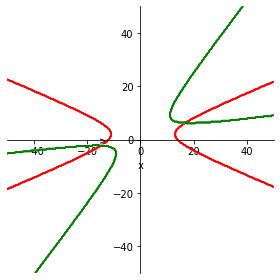

In [5]:

from sympy.abc import x, y
display(Hyp1.equation(_slope=sympy.tan(30 * sympy.pi / 180), equation=True))
p = plot_implicit(Hyp1.equation(x=x, y=y), (x, -50, 50), (y, -50, 50),
                  line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)
p.extend(plot_implicit(Hyp1.equation(x=x, y=y, _slope=sympy.tan(30 * sympy.pi / 180), equation=True), (x, -50, 50), (y, -50, 50),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

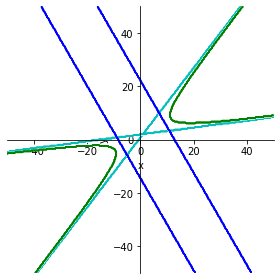

In [6]:

angle = 30 * sympy.pi / 180
asymp = Hyp1.asymptote(x=x, y=y, _angle=angle)
dir = Hyp1.directrix(x=x, y=y, _angle=angle)
xlim = (x, -50, 50)
ylim = (y, -50, 50)
p = plot_implicit(asymp[0], xlim, ylim, line_color='c', aspect_ratio=(1, 1), show=False, adaptive=False)
p.extend(plot_implicit(asymp[1], xlim, ylim, line_color='c', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(dir[0], xlim, ylim, line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(dir[1], xlim, ylim, line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Hyp1.equation(x=x, y=y, _slope=sympy.tan(angle), equation=True), xlim, ylim, line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.show()

###  Индивидуальное задание
Определить гиперболу с центром в $(X, Y)$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнение повернутой гиперболы.